In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (24, 8)

from pathlib import Path
import json

In [2]:
def readDfFromDir(path):
    json_files = list(path.glob('*.json'))
    dfs = [pd.DataFrame(json.loads(line) for line in f.read_text().splitlines()) for f in json_files]
    return pd.concat(dfs)

BASE_DIR = Path('data')

# Read raw data to dataframes from corresponding directories
product_invoices_raw = readDfFromDir(BASE_DIR.joinpath('product_invoices'))
provider_invoices_raw = readDfFromDir(BASE_DIR.joinpath('provider_invoices'))
shipments_raw = readDfFromDir(BASE_DIR.joinpath('product_shipments'))

package_types_raw = readDfFromDir(BASE_DIR.joinpath('product_package_types'))
provider_prices_raw = readDfFromDir(BASE_DIR.joinpath('provider_prices'))

*Note: 
* The business process as I understood it from Vinted Help section on the website and the data received:

* 1. The seller uploads an item and chooses a parcel type (eg 0.5/1/2/kg). 
* 2. Once buyer buys that item, the seller receives a shipping label (which includes a track number). The shipping label is generated accordingly to the sellers description. The buyer is paying for the delivery accordingly to the sellers choice a well. This action is considered as a transaction in product_shipments. If the seller/buyer/Vinted cancels the order, the transaction is cancelled ( https://www.vinted.com/help/459-why-did-vinted-cancel-my-transaction?access_channel=hc_topics )
* 3. Vinted (not the seller) receives the payment. Buyers delivery payments are stored in product_invoices.
* 4. That seller comes to a post office to send the parcel. The parcels is weighed, and the provider updates information about the parcel. Here the shipment price can change: increase if the parcel is bigger than sellers description, and decrease if it's smaller. If the price is bigger/smaller, that does not affect buyer's payment for the delivery through Vinted. Buyer's delivery payment (the Vinted-through one) stays the same. ( https://www.vinted.com/help/160-wrong-shipping-size-was-selected-now-what ). If the shipment is bigger than expected, buyer or seller pays for that directly at the post office (or at the delivery moment) without Vinted intervention.
* 5. After all that Vinted receives updated info from the provider about the shipping labels (or Vinted gets it regularly from the very creation moment, but storing (at least at the sample) the latest values).

In [3]:
# Prepare product & provider invoices dataframes to join with the shipments
df_product_invoices = product_invoices_raw.rename({'amount': 'buyer_invoice_price'}, axis=1)
df_provider_invoices = provider_invoices_raw.rename({'from_country': 'provider_from_country', 'to_country': 'provider_to_country', 'amount': 'provider_invoice_price'}, axis=1)
df_package_types = package_types_raw.rename({'id': 'package_type_id', 'description': 'package_type_description'}, axis=1)

# Join
df_shipments_joined = shipments_raw
df_shipments_joined = df_shipments_joined.merge(df_product_invoices, how='inner', on='transaction_id')
df_shipments_joined = df_shipments_joined.merge(df_provider_invoices, how='inner', on='tracking_code')
df_shipments_joined = df_shipments_joined.merge(df_package_types, how='inner', on='package_type_id')

# Checking #rows in each table to estimate data consistency
print('#shipments rows', shipments_raw.shape[0])
print('#product invoices rows', product_invoices_raw.shape[0])
print('#provider invoices rows', provider_invoices_raw.shape[0])
print('#joined rows', df_shipments_joined.shape[0])
print('ratio shipments/joined shipment rows',  df_shipments_joined.shape[0] / shipments_raw.shape[0])

#df_shipments_joined.head(1)

#shipments rows 562886
#product invoices rows 554038
#provider invoices rows 562943
#joined rows 554042
ratio shipments/joined shipment rows 0.9842881151778513


*Note: 
* Vinted has no invoices for 1.6% of shipments - those could be cancelled and Vinted would'd not received buyers invoices for them.*

In [4]:
# Add auxillary columns to the joined dataframe for an easier analysis in the future

# Compute the difference between buyers and provider's prices
df_shipments_joined['buyer_provider_price_diff'] = df_shipments_joined['buyer_invoice_price'] - df_shipments_joined['provider_invoice_price']

# Extract date and month from shpping label creation
df_shipments_joined['shipping_label_created'] = pd.to_datetime(df_shipments_joined['shipping_label_created'], infer_datetime_format=True)
df_shipments_joined['shipping_label_created_month'] =  pd.to_datetime(df_shipments_joined['shipping_label_created'].dt.to_period('M').astype('str') + '-01')

# Rearrange columns for better visual comparison
df_shipments_joined = df_shipments_joined[['package_type_id', 'package_type_description', 'from_country', 'to_country',
                                           'provider_from_country', 'provider_to_country',
                                           'shipping_label_created', 'user_invoice_date', 'shipping_label_created_month',
                                           'buyer_invoice_price', 'provider_invoice_price', 'buyer_provider_price_diff', 
                                           'weight_measured',
                                           'buyer_id', 'seller_id', 'tracking_code', 'transaction_id']]

#df_shipments_joined.head(1)

In [5]:
shipments_with_invalid_price = df_shipments_joined['buyer_provider_price_diff'] != 0
print('Fraction of shipments with price inconsistency: {:.2f}'.format(shipments_with_invalid_price.sum() / df_shipments_joined.shape[0]))

Fraction of shipments with price inconsistency: 0.34


*Note: 
* Seems like a third of all invoices from buyers are different from providers invoices. 
* Vinted website mentioned it's a sellers responsibility to provide correct data about shipments, so it could be needed to provide sellers more information about that.
* Dealing with an irresponsible seller (when buyer have to pay extra on delivery) could lead to a negative customer experience, which is obviously not really good for a c2c platform.

In [6]:
# Check if users might send packages to wrong country
df_shipments_joined[(df_shipments_joined['from_country'] != df_shipments_joined['provider_from_country']) | (df_shipments_joined['to_country'] != df_shipments_joined['provider_to_country'])]

,package_type_id,package_type_description,from_country,to_country,provider_from_country,provider_to_country,shipping_label_created,user_invoice_date,shipping_label_created_month,buyer_invoice_price,provider_invoice_price,buyer_provider_price_diff,weight_measured,buyer_id,seller_id,tracking_code,transaction_id
5031,11,1kg,FR,FR,ES,FR,2015-05-19 18:50:57,2015-05-26,2015-05-01,2.730000,3.73,-1.000000,0.0,1702596,105141,12878564,8638716
112847,11,1kg,FR,FR,ES,FR,2015-04-25 20:07:56,2015-05-05,2015-04-01,2.730000,3.73,-1.000000,0.0,1827490,1164460,12795958,7789938
552250,135,1kg,ES,FR,FR,FR,2019-02-26 12:14:31,2019-03-06,2019-02-01,3.727273,3.28,0.447273,NaN,11869825,21649195,12878564,271780177
552586,135,1kg,ES,FR,FR,FR,2019-02-11 16:54:05,2019-02-19,2019-02-01,3.727273,3.28,0.447273,NaN,21341323,22008389,12795958,260812237


*Note: 
* only 4 shipments changed source country. So these are almost impossible cases.

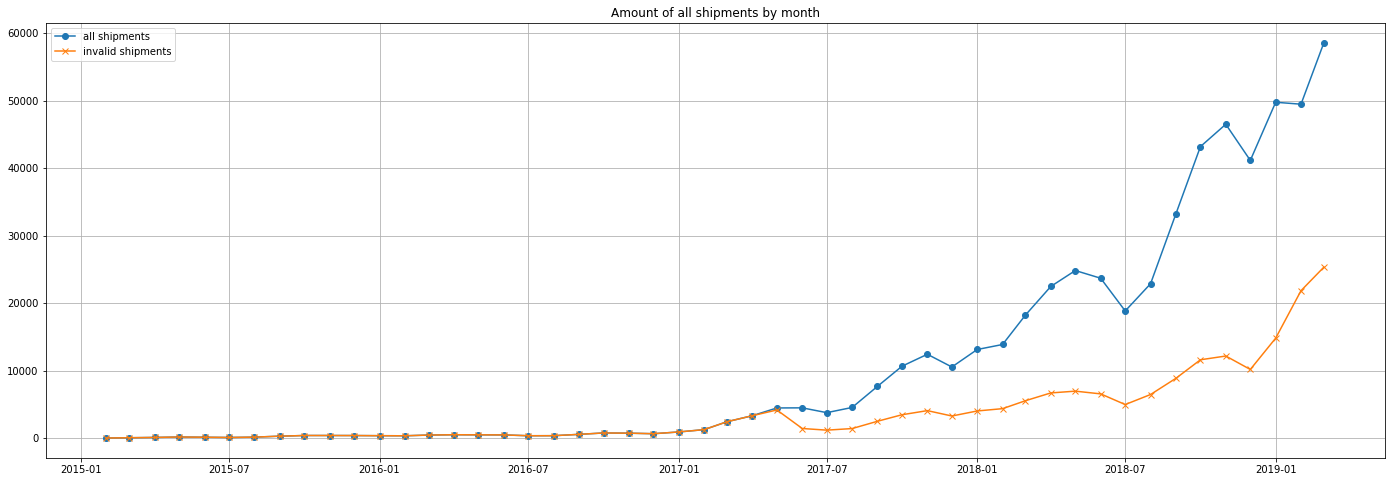

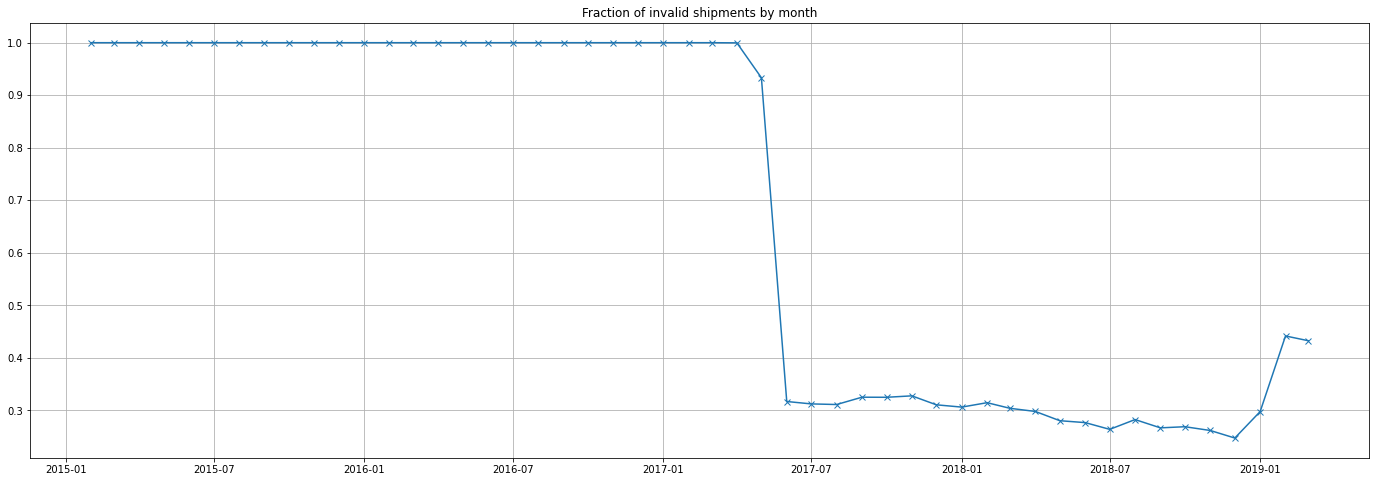

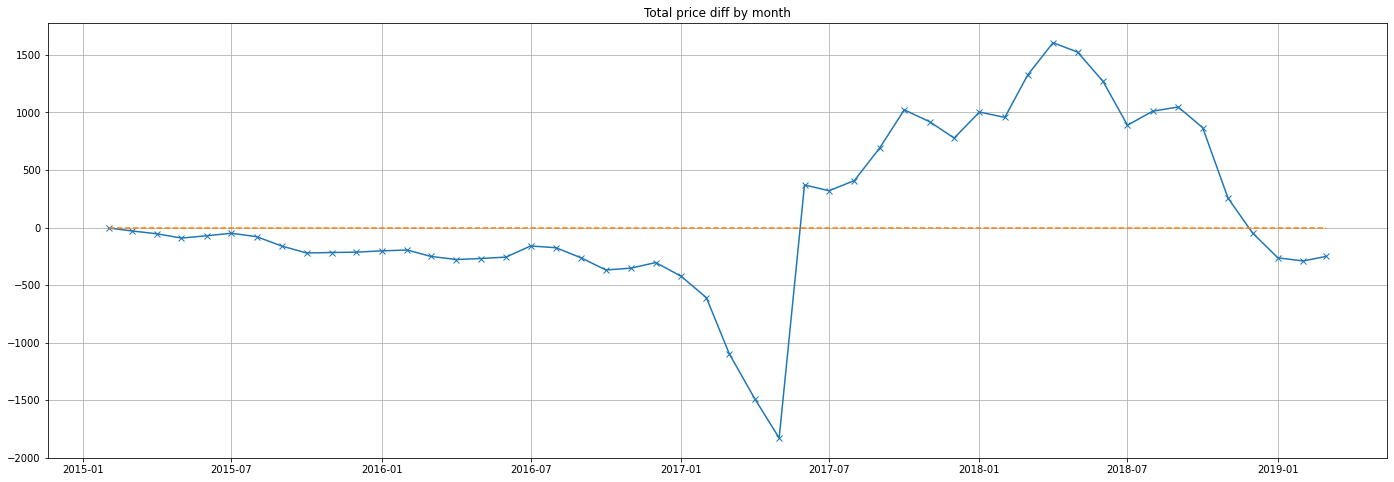

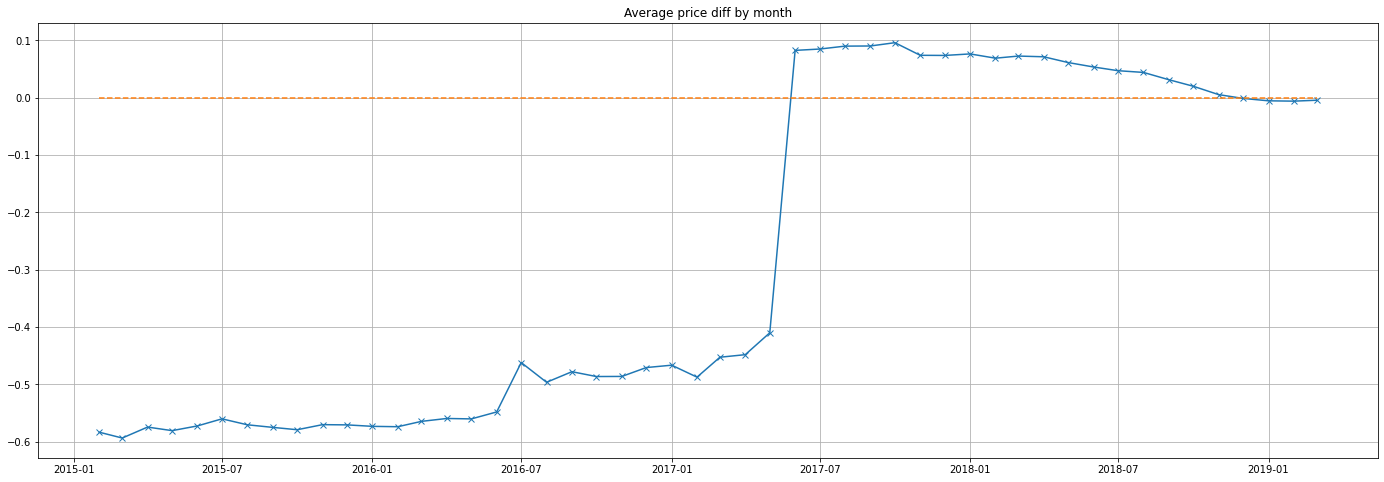

In [7]:
# Draw monthly #shipments, total and average price difference

# To be used as aggregation for function for buyer_provider_price_diff column
def num_shipments_with_incorrect_prices(agg_array):
    return int(np.count_nonzero(agg_array))

df_month_trends = df_shipments_joined.groupby('shipping_label_created_month').agg({'buyer_provider_price_diff': ['sum', 'mean', 'count', num_shipments_with_incorrect_prices]}).sort_index()
df_month_trends.columns = df_month_trends.columns.droplevel(0)

plt.figure()
plt.title('Amount of all shipments by month')
plt.plot(df_month_trends.index, df_month_trends['count'], label='all shipments', marker='o')
plt.plot(df_month_trends.index, df_month_trends['num_shipments_with_incorrect_prices'], label='invalid shipments', marker='x')
plt.legend()
plt.grid()

plt.figure()
plt.title('Fraction of invalid shipments by month')
plt.plot(df_month_trends.index, df_month_trends['num_shipments_with_incorrect_prices'] / df_month_trends['count'], marker='x')
plt.grid()

dates_range = df_month_trends.index[[0, -1]]

plt.figure()
plt.title('Total price diff by month')
plt.plot(df_month_trends.index, df_month_trends['sum'], marker='x')
plt.plot(dates_range, [0, 0], linestyle='dashed')
plt.grid()

plt.figure()
plt.title('Average price diff by month')
plt.plot(df_month_trends.index, df_month_trends['mean'], marker='x')
plt.plot(dates_range, [0, 0], linestyle='dashed')
plt.grid()

Notes:
* Before June 2017 Vinted charged less money from buyers for delivery for almost 100% shipments (i.e. buyers should have paid extra 0.5 EUR for each package in average). Sellers & buyers might had been regularly facing problems with post services and paying extra at the shipping/delivery moments, so they spent more time and resources on sending/receiving process. Not a superb customer experience (:  
* But then something changed (e.g. Vinted's policies, or a possibility of return if the delivery costs are higher than expected for a buyer, or package type selection, or sellers advices were added) and Vinted started charging 0.1 EUR more from sellers in average. Also fraction of incorrectly priced shipments dropped to 30%.
* The latest data from 2019 show that Vinted charges almost exact shipping cost from buyers. This could probably show results of working with sellers on how they shouls measure their shipments.

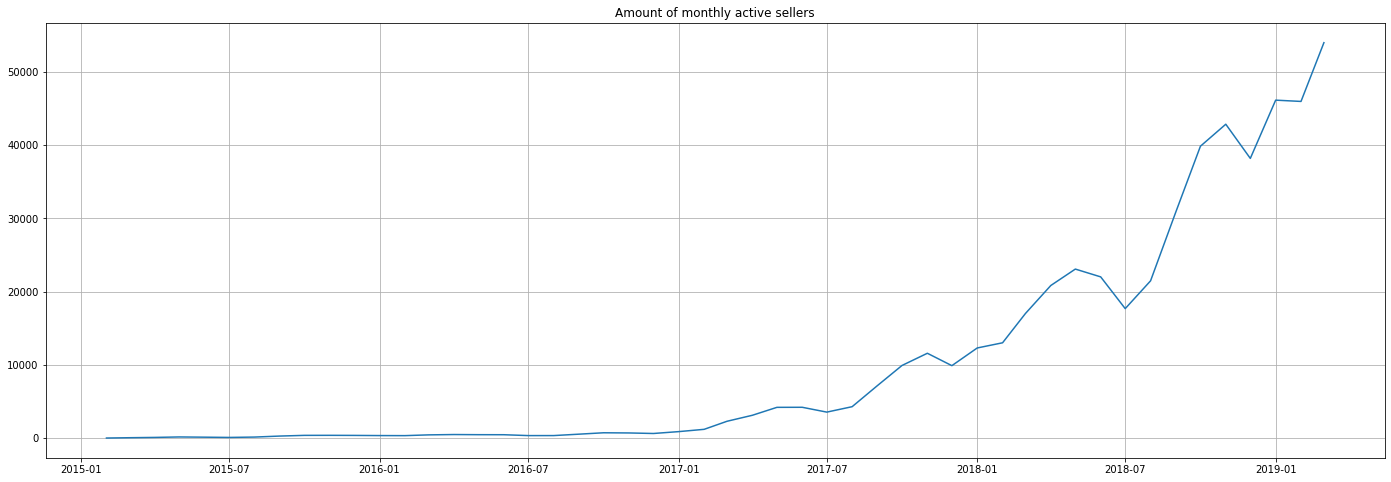

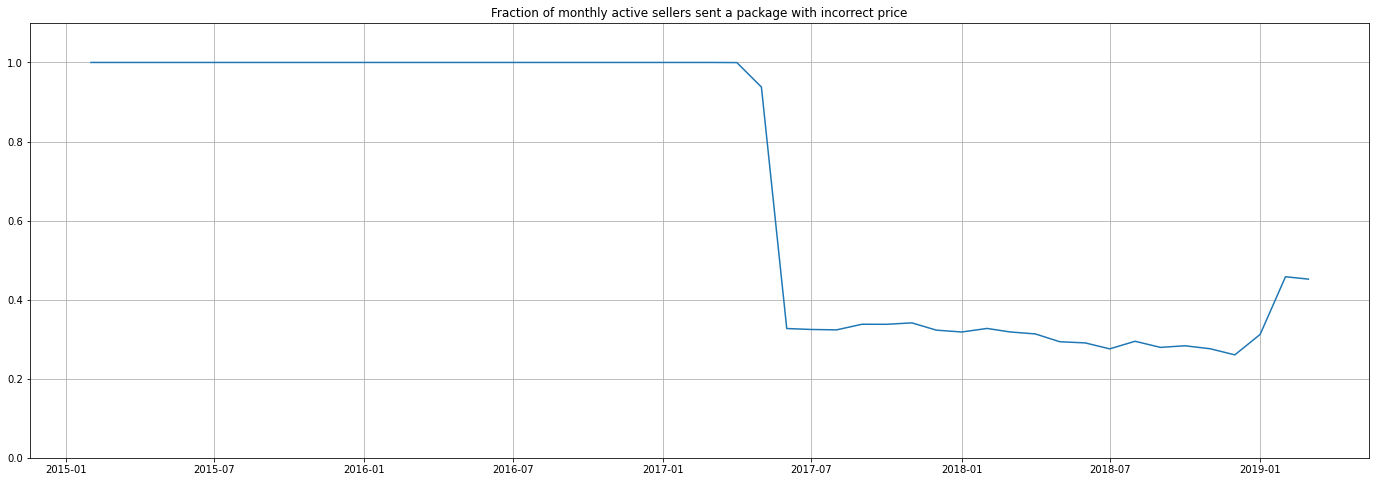

In [8]:
# let's compute monthly active sellers and fraction of sellers making mistakes

def drawMAU():
    df = df_shipments_joined
    df_mau = df.groupby('shipping_label_created_month').agg({'seller_id': pd.Series.nunique}).sort_index()
    
    plt.figure()
    plt.plot(df_mau.index, df_mau['seller_id'])
    plt.title('Amount of monthly active sellers')
    plt.grid()
    
    df_invalid_prices = df[df['buyer_provider_price_diff'] != 0]
    df_mau_invalid_prices = df_invalid_prices.groupby('shipping_label_created_month').agg({'seller_id': pd.Series.nunique}).sort_index().align(df_mau)[0]
    
    plt.figure()
    plt.plot(df_mau.index, df_mau_invalid_prices['seller_id'] / df_mau['seller_id'])
    plt.title('Fraction of monthly active sellers sent a package with incorrect price')
    plt.grid()
    plt.ylim([0, 1.1])
    
drawMAU()

Notes:
* The number of users in 2017 started to increase. Maybe that was one of the reasons to introduce changes on shipping process mentioned in the previous notes - more customers could receive more negative customers experience with complicated extra-paying delivery/sending processes. Also after June 2017 amount of users started to grow rapidly (possibly marketing & more positive feedbacks without delivery issues)
* In 2017 users started to sell more responsibly: the fraction of sellers which noted wrong shipment type dropped from 100% to ~35%
* Number of monthly active sellers approximates to the number of monthly shipments (55K vs 60K)
* Fraction of "inaccurate" sellers (who sent a package with incorrectly specified shipment price) is the same as fraction of incorrectly priced shipments. This means that "inaccurate" sellers are distributed uniformly among sellers i.e. we don't have a narrow set of "inaccurate" sellers.

from_country
FR    547178
BE      5737
ES      1115
LU        12
dtype: int64


Text(0.5, 1.0, 'Fraction of shipments with mismatched prices by country')

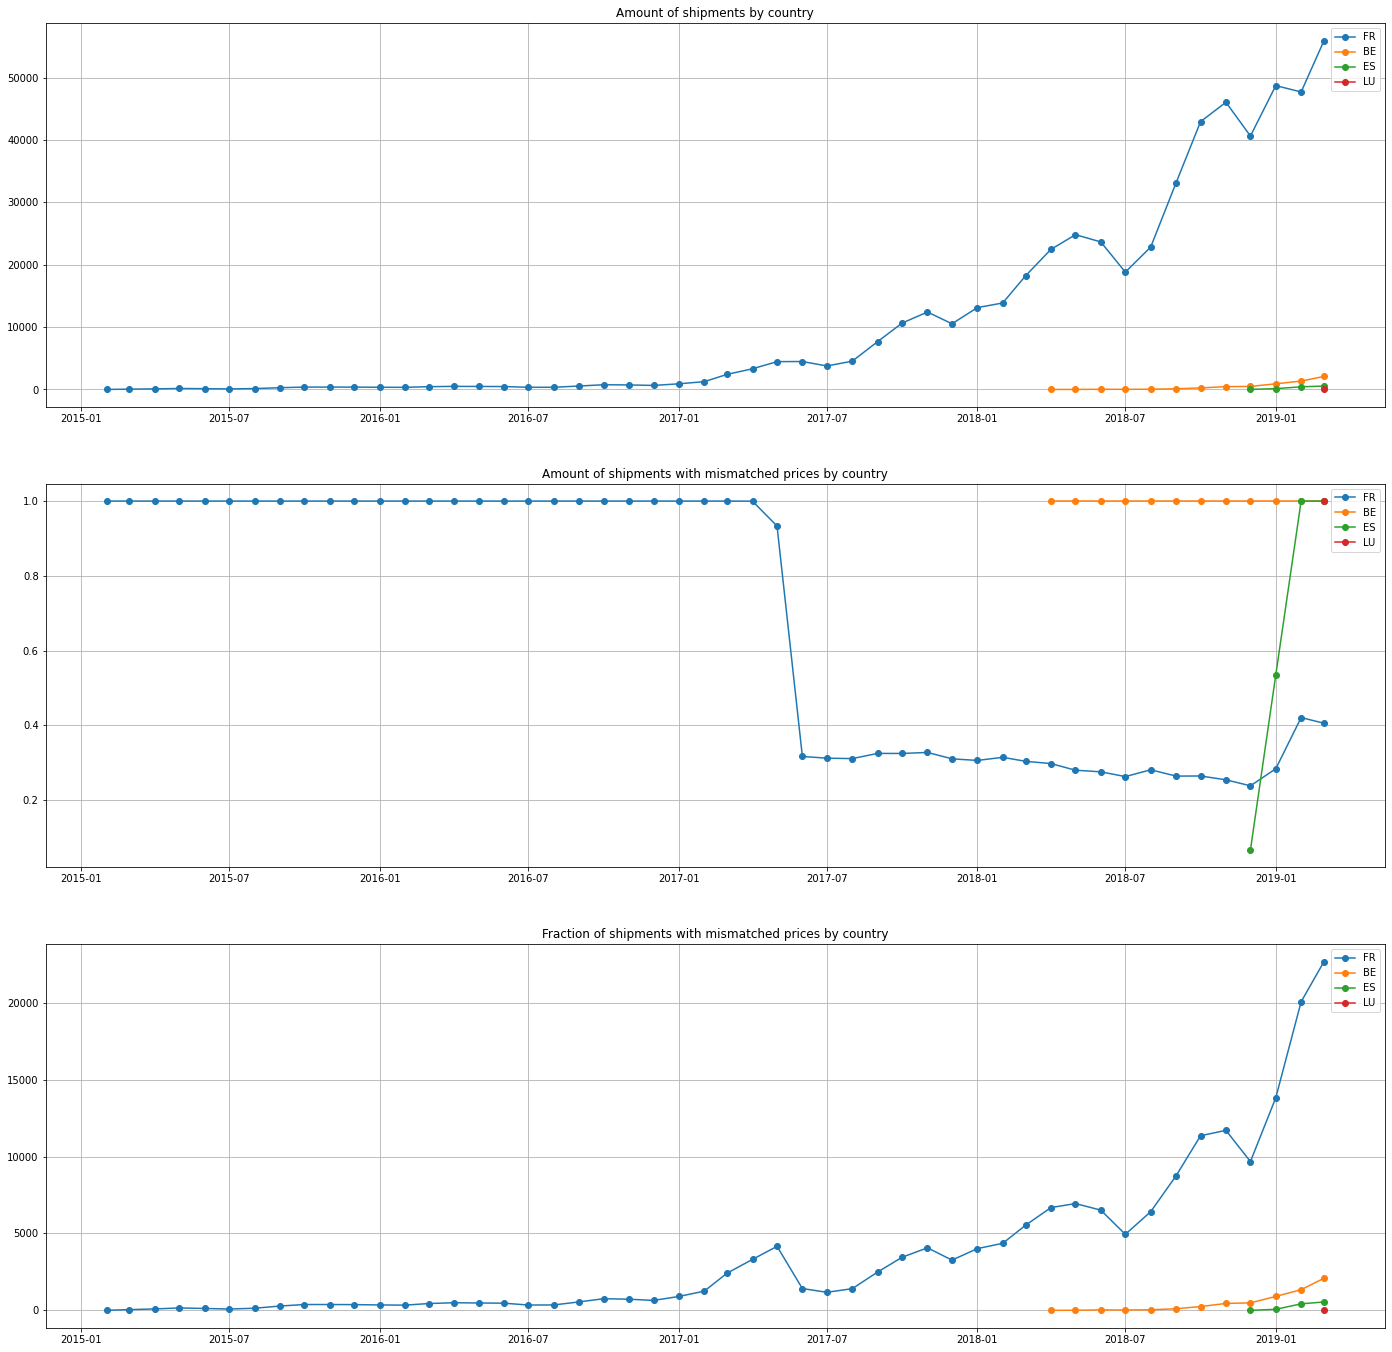

In [13]:
# These inaccuracies are introduced by sellers (by incorrectly choosing type of package), so look only at source country

df_shipments_by_country = df_shipments_joined.groupby('from_country').size().sort_values(ascending=False)
print(df_shipments_by_country)

all_countries = df_shipments_by_country.index.to_list()

fig, axes = plt.subplots(3, 1, figsize=(24, 24))

def drawCountryPlot(country):
    df = df_shipments_joined[df_shipments_joined['from_country'] == country]
    
    df_month_trends = df.groupby('shipping_label_created_month').agg({'buyer_provider_price_diff': ['count', num_shipments_with_incorrect_prices]}).sort_index()
    df_month_trends.columns = df_month_trends.columns.droplevel(0)
    
    axes[0].plot(df_month_trends.index, df_month_trends['count'], label=country, marker='o')
    axes[1].plot(df_month_trends.index, df_month_trends['num_shipments_with_incorrect_prices'] / df_month_trends['count'], label=country, marker='o')
    axes[2].plot(df_month_trends.index, df_month_trends['num_shipments_with_incorrect_prices'], label=country, marker='o')
    
for country in all_countries:
    drawCountryPlot(country)

for a in axes:
    a.legend()
    a.grid()

axes[0].set_title('Amount of shipments by country')
axes[1].set_title('Amount of shipments with mismatched prices by country')
axes[2].set_title('Fraction of shipments with mismatched prices by country')

Notes:
* Most of the sellers are located in France. Belgium and Spain were launched in 2018, Luxembourg in 2019.
* France sellers used to have 100% of mismatched shipping prices, but it was dropped to 30-40% in 2017.
* Belgium, Spain and Luxembourg now have 100% of mismatched shipping prices - there is a room for improvement for these countries. Even though Spain had very low rate of incorrectly priced shipments at the launch.
* Altough Belgium, Spain and Luxembourg have very high rate of incorrectly priced shipments, they have low contribution to the total rate since these countries have less 10% of all shipments.

package_type_description
0.5kg    263234
1kg      186853
2kg      103831
5kg          82
10kg         23
20kg         19
dtype: int64


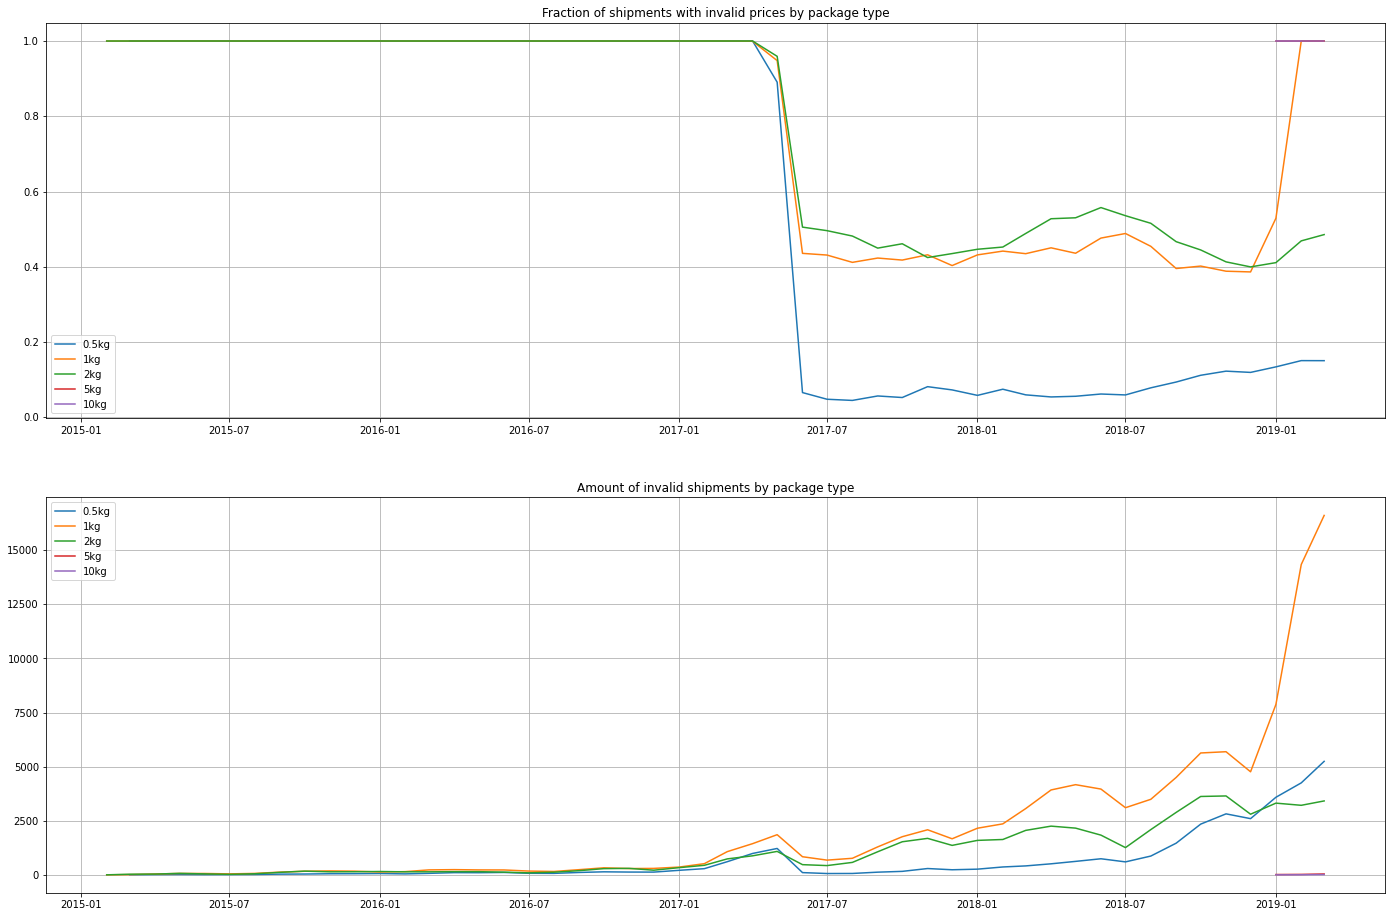

In [10]:
# Let's analyze which package types are most error-prone

df_shipments_by_package_type = df_shipments_joined.groupby('package_type_description').size().sort_values(ascending=False)
print(df_shipments_by_package_type)

top5_package_type_descs = df_shipments_by_package_type.head(5).index.to_list()

fig, axes = plt.subplots(2, 1, figsize=(24, 16))

def drawPackagePlot(package_type_description):
    df = df_shipments_joined[df_shipments_joined['package_type_description'] == package_type_description]
    df_invalid_prices = df[df['buyer_provider_price_diff'] != 0]
    
    df_month_trends = df.groupby('shipping_label_created_month').agg({'buyer_provider_price_diff': ['count', num_shipments_with_incorrect_prices]}).sort_index()
    df_month_trends.columns = df_month_trends.columns.droplevel(0)

    axes[0].plot(df_month_trends.index, df_month_trends['num_shipments_with_incorrect_prices'] / df_month_trends['count'], label=package_type_description)
    axes[1].plot(df_month_trends.index, df_month_trends['num_shipments_with_incorrect_prices'], label=package_type_description)

for package_type_description in top5_package_type_descs:
    drawPackagePlot(package_type_description)

axes[0].set_title('Fraction of shipments with invalid prices by package type')
axes[0].legend()
axes[0].grid()

axes[1].set_title('Amount of invalid shipments by package type')
axes[1].legend()
axes[1].grid()

Notes:
* 1kg package is the most popular and most error-prone package (at the latest data its fraction of incorrectly priced shipments reached 100%)
* 0.5 kg is becoming the second most popular, but has much lower error rate (10-20%). If 0.5 kg is a default package in UI, this might explain such a high error rate
* Vinted might need to track "erorr rate" of each type of package to make descision regarding UI/UX improvements. For example Vinted can provide sellers advice nots: average weight of jeans, jackets etc. to help them choose the right package.

In [11]:
# let's check if we have "bad" sellers who regularly chose incorrect shipment

# Top 10 users by number of incorrect shipments
df = df_shipments_joined.groupby('seller_id').agg({'buyer_provider_price_diff': ['count', 'sum', num_shipments_with_incorrect_prices]})
df.columns = df.columns.droplevel(0)

df = df.sort_values(by='num_shipments_with_incorrect_prices', ascending=False)
df.head(10)

,count,sum,num_shipments_with_incorrect_prices
seller_id,,,
12661066,31,8.400000,25.0
791421,45,-10.666667,25.0
561143,68,-7.086669,24.0
379461,42,0.376666,19.0
13390476,35,-18.980000,19.0
9319026,38,-8.993334,18.0
9319418,23,4.673333,18.0
14167001,37,-7.380000,18.0
1567268,24,1.770000,17.0


Notes:
* There is a user who sent 25 of 31 packages with incorrect shipment prices (and "earned" 8.4 EUR,  if the sellers receive the buyers delivery expenses directly. Or accidently "earned" it for Vinted)
* Still it doesn't seem that users massively choose wrong packages

num_all_shipments 554042
shipments_with_weight_intervals 554042
shipments_with_available_weight_from_provider 405770

OrderedDict([('shipemnts_with_weight_mismatch', 161612),
             ('shipemnts_with_price_mismatch', 165011),
             ('shipemnts_with_weight_and_price_mismatch', 146161)])
OrderedDict([('shipemnts_with_over_weight', 60710),
             ('shipemnts_with_over_price', 53201),
             ('shipemnts_with_over_weight_and_over_price', 44047),
             ('shipemnts_with_under_weight', 100902),
             ('shipemnts_with_under_price', 111810),
             ('shipemnts_with_under_weight_and_under_price', 97421)])
Types of packages for which shipping providers dosn't provide weight data: package_type_description
0.5kg    77433
1kg      45835
2kg      24956
5kg         19
20kg        16
10kg        13
dtype: int64


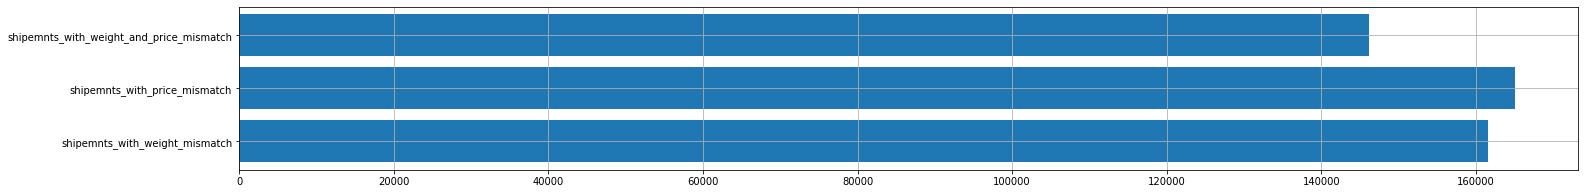

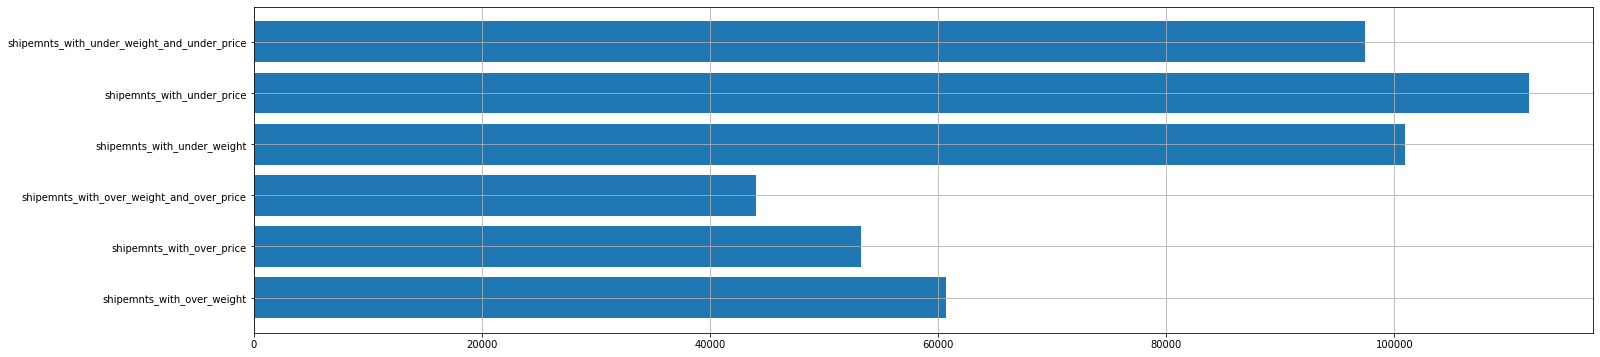

In [12]:
# Let's compare actual package weight (from provider) and weight specified by seller (by package_type_id).
# Also let's check overweight/underweight affects provider price 
from pprint import pprint
from collections import OrderedDict

package_description_to_weight_interval = {
    '0.5kg': [0, 0.5],
    '1kg': [0.5, 1],
    '2kg': [1, 2],
    '5kg': [2, 5],
    '10kg': [5, 10],
    '20kg': [10, 20]
}

df_shipments_joined_with_weight_intervals = df_shipments_joined[['buyer_provider_price_diff', 'weight_measured', 'package_type_description']].copy()
df_shipments_joined_with_weight_intervals['weight_interval'] = df_shipments_joined['package_type_description'].transform(lambda desc: package_description_to_weight_interval.get(desc))
df_shipments_joined_with_weight_intervals['has_provided_weight'] = df_shipments_joined_with_weight_intervals['weight_measured'].transform(lambda x: x > 0 and not np.isnan(x))

# Check that we managed to join all packages

print('num_all_shipments', df_shipments_joined_with_weight_intervals.shape[0])
print('shipments_with_weight_intervals', df_shipments_joined_with_weight_intervals['weight_interval'].transform(bool).sum())
print('shipments_with_available_weight_from_provider', df_shipments_joined_with_weight_intervals['has_provided_weight'].sum())
print()

df = df_shipments_joined_with_weight_intervals[df_shipments_joined_with_weight_intervals['has_provided_weight']]

def drawHBar(kv):
    pprint(kv)
    plt.figure(figsize=(24, len(kv)))
    plt.barh(tuple(kv.keys()), kv.values())
    plt.grid()

drawHBar(OrderedDict([
    ('shipemnts_with_weight_mismatch', 
         df.apply(lambda row: not (row['weight_interval'][0] < row['weight_measured']/1000 <= row['weight_interval'][1]), axis=1).sum()),
    ('shipemnts_with_price_mismatch',
         df.apply(lambda row: row['buyer_provider_price_diff'] != 0, axis=1).sum()),
    ('shipemnts_with_weight_and_price_mismatch',
         df.apply(lambda row: not (row['weight_interval'][0] < row['weight_measured']/1000 <= row['weight_interval'][1]) and row['buyer_provider_price_diff'] != 0, axis=1).sum())
]))

drawHBar(OrderedDict([
    ('shipemnts_with_over_weight',
         df.apply(lambda row: row['weight_measured']/1000 > row['weight_interval'][1], axis=1).sum()),
    ('shipemnts_with_over_price',
         df.apply(lambda row: row['buyer_provider_price_diff'] < 0, axis=1).sum()),
    ('shipemnts_with_over_weight_and_over_price',
         df.apply(lambda row: row['weight_measured']/1000 > row['weight_interval'][1] and row['buyer_provider_price_diff'] < 0, axis=1).sum()),

    ('shipemnts_with_under_weight',
         df.apply(lambda row: row['weight_measured']/1000 <= row['weight_interval'][0], axis=1).sum()),
    ('shipemnts_with_under_price',
         df.apply(lambda row: row['buyer_provider_price_diff'] > 0, axis=1).sum()),
    ('shipemnts_with_under_weight_and_under_price',
         df.apply(lambda row: row['weight_measured']/1000 <= row['weight_interval'][0] and row['buyer_provider_price_diff'] > 0, axis=1).sum())
]))

print("Types of packages for which shipping providers dosn't provide weight data:",
    df_shipments_joined_with_weight_intervals[~df_shipments_joined_with_weight_intervals['has_provided_weight']].groupby('package_type_description').size().sort_values(0, ascending=False))

Notes:
* **Improperly chosen packet weight by seller is the major reason of the the shipping price difference**:
  * 146K of 165K (88%) shipment with the price mistmach also had weight mismatch (i.e. sellers chose a packet which cannot handle the weight of shipped product).
* Sellers tend to pick heavier packet than they need:
  * 100K of these 165K cases it was underweight (i.e. actual shipment was lighter than declared one and can be shipped in a smaller/ligheter packet)
      * In 96% of such shipments shipment provider charged less money than seller initially declared
  * 60K of these 165K cases it was overweight (i.e. actual shipment was heavier than declared one and has to be shipped in a bigger/heavier packet)
      * In 72% of such shipments shipment provider charged more money than seller initially declared
      * I find this is a quite strange since shipment provider could charge more money in 100% of these cases.
* Shipment providers provide weight data only for 80% of shipments.

Pssible improvement:
* To improve user experience and reduce the ratio of shipments with price mistmatch we can give sellers inidividual suggestions about package sizes based on their previous shipments.
* For example, based on the weight data from shipment providers we know that a seller sent 0.4 kg jeans in a 1kg package.
* Next time this seller tries to use 1kg package for jeans we might say him/her: "Hey, you previous jeans could be fit in 0.5 kg package. Do you want to use 0.5kg insted of 1kg packet this time?"
* However, we will not be able to implement this suggestion in all cases since we have weight data only for 80% of shipments.

TODO:
    
* Break down weight analysis data on different dimensions like country and date to get better understanding when/where over/underweight happen and how it influences shipping price.
* Analyze which other factors except package type and weight causes shipping price mismatch.
* Do more analysis with new data:
  * I'd like to get more data, especially I'm interested in attributes of selling products (e.g. category and material).
  * For example, if we know which category a particular product belgogs to (e.g. T-shirt, jackets, etc) or material (e.g. cotton, leather). We might analyze correlation between category and shipping price mismtach.
  * Based on this data we might identify categories of products that have highest shopping price mitmatch rate.
  * Since we know these attributes in advance (before a byuer finds the product), we might give sellers recommendations about typical package size for this category.
  * We can even build a simple ML model which predicts package type (or shipping price mistmatch) based on product's attributes.